# 2D slopes

QG theory suggests that the slopes/aspect ratio of tracer filaments would go like N/f:
\begin{equation}
\frac{|\phi_z|}{|\phi_x|} = N/f
\end{equation}
for smoothhy varying background gradients (which is the case for our region). 
(Slope is like $dz/dx$, which will go like f/N). 

In [4]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

from scipy import interpolate

import extra_funcs as ef

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 8

In [3]:
ds_659_rho = xr.open_dataset('../data/sg_659_iso_grid.nc')
ds_660_rho = xr.open_dataset('../data/sg_660_iso_grid.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)

#
dCT_659 = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA_659 = ds_659_rho.SA  - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT_659).rename('Spice')

# remove a mean per isopycnal
dCT_660 = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA_660 = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT_660).rename('Spice')

In [5]:
ds_659_rho_dist = xr.merge( [#interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             #interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             ef.interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             ef.interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

In [6]:
ds_660_rho_dist = xr.merge( [#interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             #interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             ef.interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             ef.interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

### N2 calculation 

$$N^2 = db/dz$$

where $b = -g \rho ' / \rho _0$. 



In [7]:
g = 9.81
rho0 = 1000
b = - ds_660_rho_dist.rho_grid * g /rho0

In [8]:
f = 2*2*np.pi/24/3600*np.sin(55 * np.pi/180)

In [9]:
N2_659 = -b.diff('rho_grid')/ ds_659_rho_dist.ctd_pressure.diff('rho_grid')
N2_660 = -b.diff('rho_grid')/ ds_660_rho_dist.ctd_pressure.diff('rho_grid')

In [12]:
# Function that regrids a single dive to mean P.
# Will be run in a loop to do interpolation for all dives.

def func_var_int_pmean(ds, Pmean_smooth_dist): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_dist
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [13]:
# For 659
time_ind = 0

Pmean_smooth = ds_659_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.65))

N2_on_Pmean_659 = func_var_int_pmean(N2_659.isel(distance=0), Pmean_smooth)
spice_on_Pmean_659 = func_var_int_pmean(ds_659_rho_dist.Spice.isel(distance=0), Pmean_smooth)

for dist_ind in range(1, len(ds_659_rho_dist.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_659 = xr.concat([spice_on_Pmean_659, 
                                func_var_int_pmean(ds_659_rho_dist.Spice.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')
    
    N2_on_Pmean_659 = xr.concat([N2_on_Pmean_659, 
                                func_var_int_pmean(N2_659.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')    

400
800
1200
1600
2000
2400


In [14]:
# For 660 
time_ind = 0

Pmean_smooth = ds_660_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.65))

N2_on_Pmean_660 = func_var_int_pmean(N2_660.isel(distance=0), Pmean_smooth)
spice_on_Pmean_660 = func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=0), Pmean_smooth)

for dist_ind in range(1, len(ds_660_rho_dist.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_660 = xr.concat([spice_on_Pmean_660, 
                                func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')
    N2_on_Pmean_660 = xr.concat([N2_on_Pmean_660, 
                                func_var_int_pmean(N2_660.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')        

400
800
1200
1600
2000
2400
2800
3200


In [17]:
dSdx_659 = np.abs(spice_on_Pmean_659.diff('distance')/ spice_on_Pmean_659.distance.diff('distance'))
dSdz_659 = np.abs(spice_on_Pmean_659.diff('Pmean')/ spice_on_Pmean_659.Pmean.diff('Pmean'))

dSdx_660 = np.abs(spice_on_Pmean_660.diff('distance')/ spice_on_Pmean_660.distance.diff('distance'))
dSdz_660 = np.abs(spice_on_Pmean_660.diff('Pmean')/ spice_on_Pmean_660.Pmean.diff('Pmean'))

In [18]:
Nbyf = ( 0.5*(N2_on_Pmean_659 + N2_on_Pmean_660).mean('distance'))**0.5 /f

In [20]:
H_659 , xedges, yedges = np.histogram2d(np.log10(dSdx_659[:-1,:].sel(Pmean=slice(200, 750)).values.reshape(-1)), np.log10(dSdz_659[:, :-1].sel(Pmean=slice(200, 750)).values.reshape(-1)),
           bins=[np.linspace(-11, -6, 41), np.linspace(-9, -4, 40)], density=True   );


H_660 , xedges, yedges = np.histogram2d(np.log10(dSdx_659[:-1,:].sel(Pmean=slice(200, 750)).values.reshape(-1)), np.log10(dSdz_659[:, :-1].sel(Pmean=slice(200, 750)).values.reshape(-1)),
           bins=[np.linspace(-11, -6, 41), np.linspace(-9, -4, 40)], density=True   );


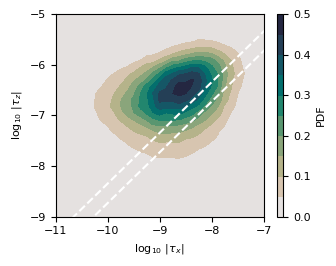

In [30]:
plt.figure(figsize=(3.4, 2.7))
plt.subplot(111)

plt.contourf(xedges[:-1], yedges[:-1], 0.5*(H_659 + H_660).T, levels=np.linspace(0, 0.5,11), cmap=cmo.rain)

plt.plot(xedges, xedges + np.log10(Nbyf.sel(Pmean=slice(200, 750)).max().values),'--', color='w')
plt.plot(xedges, xedges + np.log10(Nbyf.sel(Pmean=slice(200, 750)).min().values),'--', color='w')

plt.colorbar(aspect=30, label='PDF')

plt.axis([-11, -7, -9, -5])

plt.yticks(ticks=[-9, -8, -7, -6, -5])

plt.xlabel(r'log$_{10}$ $|\tau _x|$')
plt.ylabel(r'log$_{10}$ $|\tau _z|$')

plt.tight_layout()
plt.savefig('./figures/figures_slope_pdf.pdf')

In [25]:
AR_659 = dSdz_659.mean('distance') / dSdx_659.mean('distance')
AR_660 = dSdz_660.mean('distance') / dSdx_660.mean('distance')

AR = 0.5* (AR_659 + AR_660)

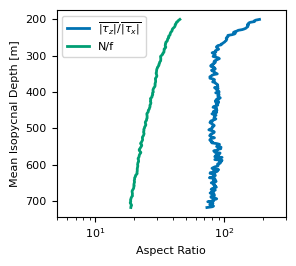

In [29]:
plt.figure(figsize=(3., 2.7))
AR.sel(Pmean=slice(200,750)).plot(y='Pmean', label=r'$\overline{| \tau _z|} / \overline{| \tau _x|}$', linewidth=2.)
Nbyf.sel(Pmean=slice(200, 750)).plot(y='Pmean', label='N/f', linewidth=2.)
# ( (N2_on_Pmean_660**0.5) /f).sel(Pmean=slice(200, 800)).plot(y='Pmean')

plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

plt.xlabel('Aspect Ratio')
plt.ylabel('Mean Isopycnal Depth [m]')
plt.xlim([5, 300])

plt.tight_layout()
plt.savefig('./figures/figures_aspect_ratio.pdf')